## Retail Store Sales Forecasting with Neural Networks -
## Final project
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

Using TensorFlow backend.


## Load Dataset

In [2]:
data= pd.read_excel('MRP_data.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [7]:
#furniture['sales']

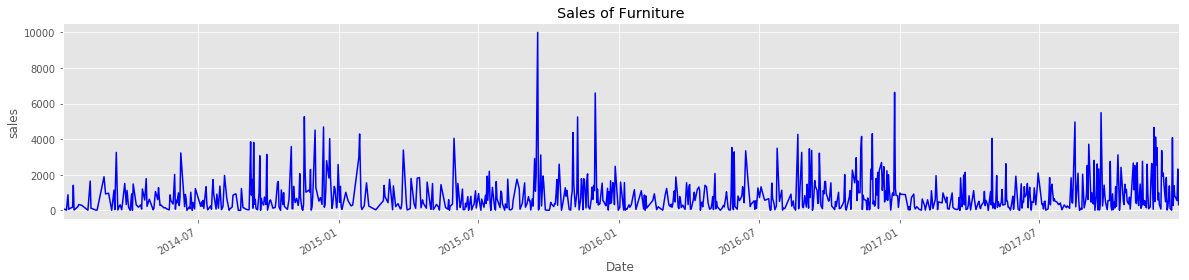

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

In [9]:
#Resampling the data on monthly frequency
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()

#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

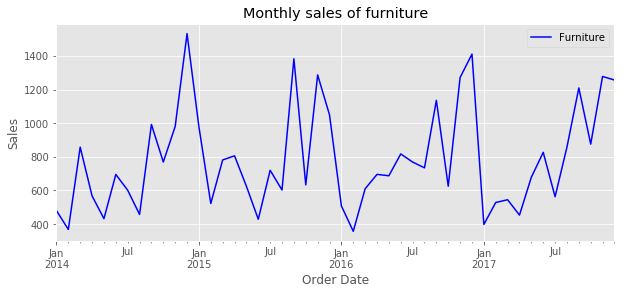

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

## Seasonal decomposition:

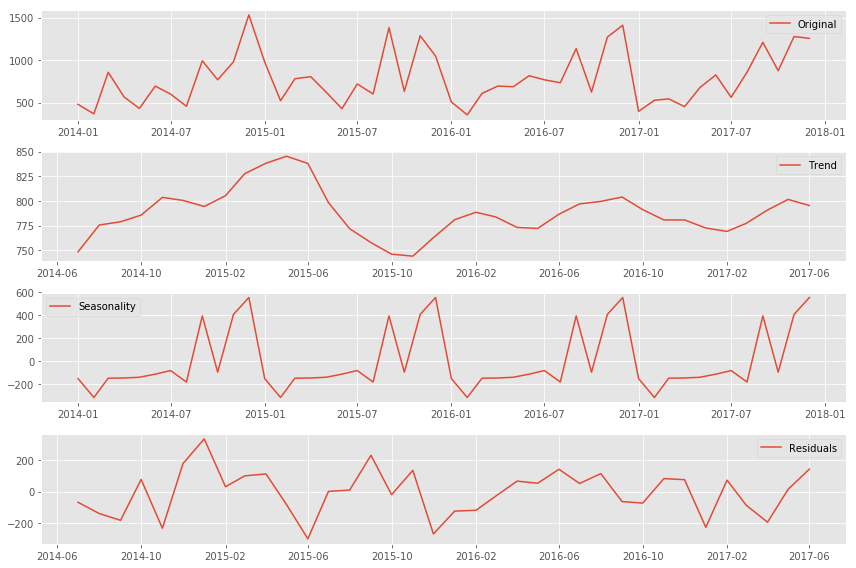

In [11]:
#Furniture time-series decomposition
decomposition = seasonal_decompose(df,freq=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

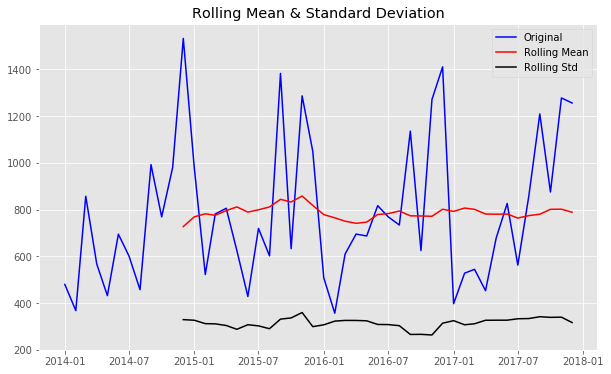

Results of Dickey-Fuller Test:
p-value= 9.168756655665942e-06


In [13]:
#check to see if the time-series is stationary or non-stationary
test_stationarity(df)
#p-value= 9.168756655665942e-06

### Train and test split

In [14]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

### Measure of prediction accuracy

In [15]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## ARMA model

In [16]:
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(trainset, order = (1,1))
model_arma_fit = model_arma.fit(disp=False)
arma_predict = model_arma_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

/Users/yas/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


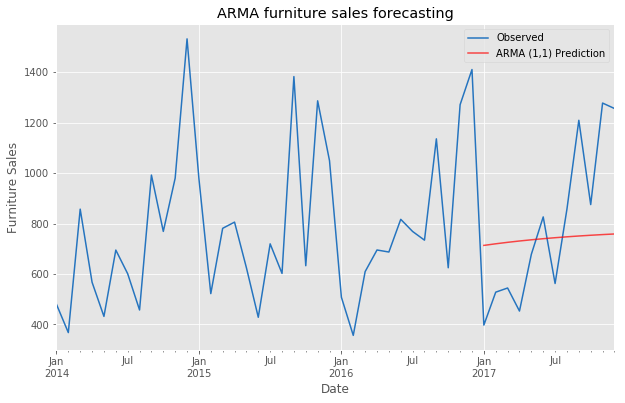

In [17]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax, label='ARMA (1,1) Prediction', alpha= 0.7, color='red') 
plt.title('ARMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()



In [18]:
arma_results= performance(df[-12:],arma_predict)
arma_results

{'MSE': 87237.01, 'RMSE': 295.36, 'MAPE': 33.88}

## ARIMA model

### Grid Search

In [19]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [20]:
# evaluate parameters
p_values = [0, 1, 2, 4,6]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=94274.549
ARIMA(0, 0, 1) MSE=87692.922
ARIMA(0, 1, 0) MSE=144690.584
ARIMA(0, 1, 1) MSE=109451.878
ARIMA(1, 0, 0) MSE=90148.329
ARIMA(1, 0, 1) MSE=77815.706
ARIMA(1, 1, 0) MSE=135393.556
ARIMA(1, 1, 1) MSE=103592.629
ARIMA(2, 0, 0) MSE=94447.876
ARIMA(2, 0, 1) MSE=94094.965
ARIMA(2, 1, 0) MSE=115636.954
ARIMA(2, 1, 1) MSE=113894.188
ARIMA(4, 0, 0) MSE=73497.716
ARIMA(4, 1, 0) MSE=116440.530
ARIMA(4, 1, 1) MSE=91729.204
ARIMA(6, 0, 0) MSE=71586.494
ARIMA(6, 1, 0) MSE=110700.341
ARIMA(6, 1, 1) MSE=91373.178
Best ARIMA(6, 0, 0) MSE=71586.494


#### Source: 
    
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [21]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(trainset, order = (6,0,0))
model_arima_fit = model_arima.fit(disp=False)
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

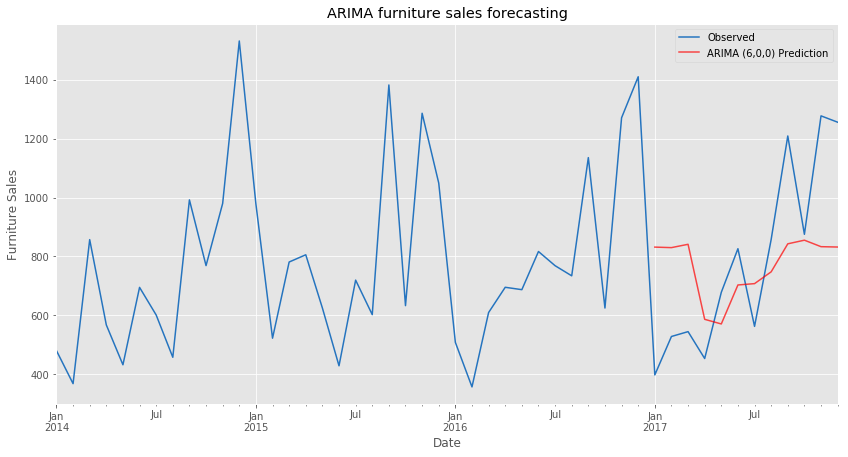

In [22]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='ARIMA (6,0,0) Prediction', alpha= 0.7, color='red') 
plt.title('ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [23]:
arima_results= performance(df[-12:],arima_predict)
arima_results

{'MSE': 79804.31, 'RMSE': 282.5, 'MAPE': 35.07}

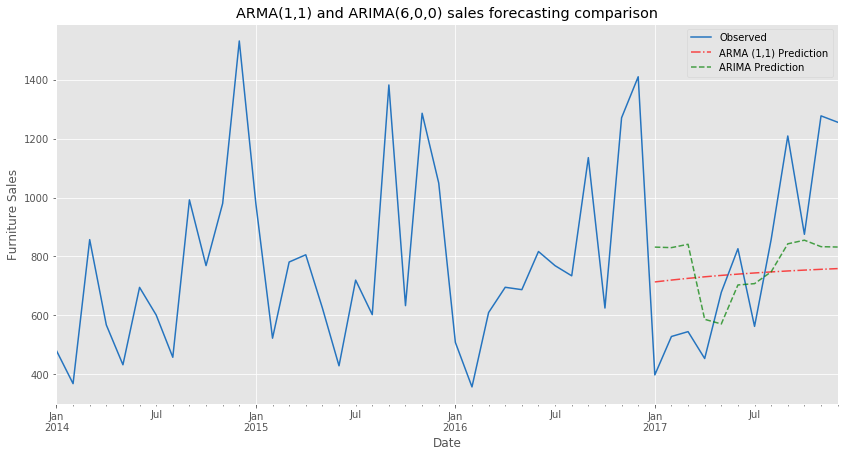

In [24]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax,label='ARMA (1,1) Prediction', linestyle= '-.', alpha= 0.7, color='r')
arima_predict.plot(ax=ax, label='ARIMA Prediction', linestyle= "--" ,alpha= 0.7, color='g')
plt.title('ARMA(1,1) and ARIMA(6,0,0) sales forecasting comparison')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()





## ACF plot

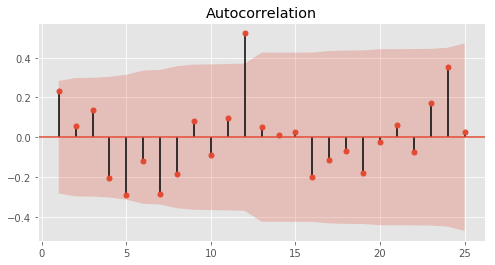

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=25)
plt.show()

#From the peaks we can see that the frequency is 12

## Seasonal ARIMA model

### Grid search method 1 - using auto-ARIMA that reported back the best AIC value.

In [26]:
## Find optimal order
import pmdarima as pm
model_1 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

# Print model summary
print(model_1.summary())

#best model is Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940,

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=338.682, BIC=341.038, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=331.614, BIC=336.327, Fit time=0.257 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=340.006, BIC=343.540, Fit time=0.079 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940, BIC=333.474, Fit time=0.197 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=331.653, BIC=336.366, Fit time=0.28

### Fitting the model

In [27]:
#fitting model
sarima_model_1 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_1 = sarima_model_1.fit()
print(sarima_fit_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6292      0.176     -3.570      0.000      -0.975      -0.284
sigma2       2.25e+04   1.57e+04      1.429      0.153   -8356.220    5.34e+04


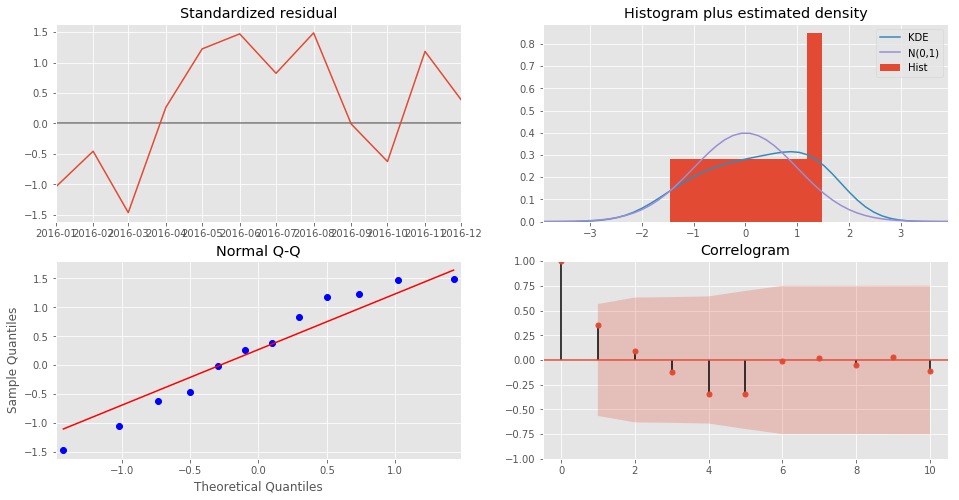

In [28]:
sarima_fit_1.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

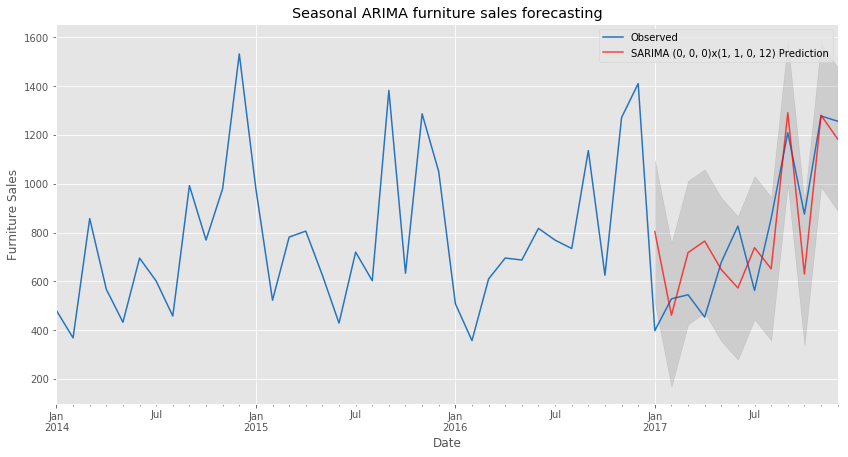

In [29]:
# One step ahead forecastorder
sarima_predict_1 = sarima_fit_1.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA (0, 0, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_1.index,
                #lower sales
                sarima_predict_conf_1.iloc[:, 0],
                #upper sales
                sarima_predict_conf_1.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [30]:
sarima_results=performance(df[-12:],sarima_predict_1.predicted_mean)
sarima_results

{'MSE': 42305.37, 'RMSE': 205.68, 'MAPE': 28.89}

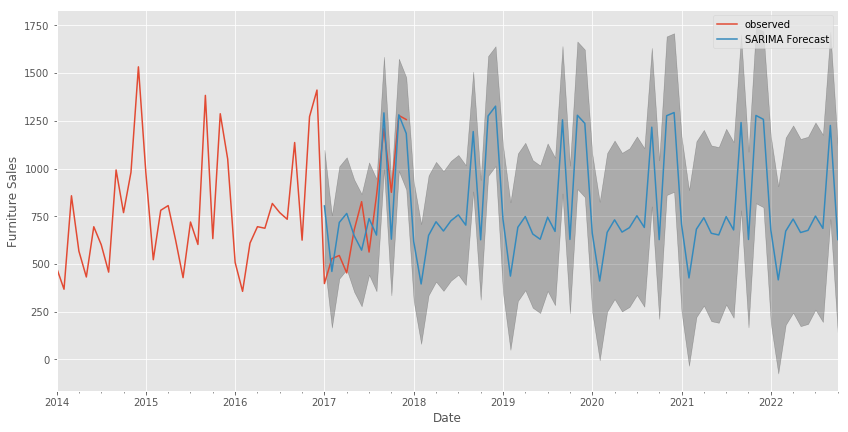

In [31]:
furthur_predict_1 = sarima_fit_1.get_forecast(steps=70)
furthur_conf_1 = furthur_predict_1.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf_1.index,
                furthur_conf_1.iloc[:, 0],
                furthur_conf_1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Grid Search meethod 2 - Develop a Grid Search Framework

In [32]:
# Define the p, d and q parameters to take a value between 0 and 2
p = d = q = range(0, 2)

# Generate different combinations of p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [33]:
#method 2
warnings.filterwarnings("ignore")
lowest_aic = sys.maxsize
lowest = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("The lowes AIC belongs to "+lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:573.2736548047211
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:320.39031701172337
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:339.13659906594717
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:158.31115188193314
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:535.956097491259
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:308.98276881122155
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:340.55729582954075
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:158.06483656135666
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:501.6523533373235
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:319.3351634712986
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:330.687098693596
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:145.77300556718512
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:477.6653149075071
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:299.4712944291711
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:327.5605738441135
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:147.21230738075826
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:516.6922617187157
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:321.

### Fitting the model

In [34]:
#fitting model
sarima_model_2 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_2 = sarima_model_2.fit()
print(sarima_fit_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1918      0.371     -0.517      0.606      -0.920       0.536
ar.S.L12      -0.4818      0.165     -2.922      0.003      -0.805      -0.159
sigma2      2.266e+04    1.8e+04      1.259      0.208   -1.26e+04    5.79e+04


### Validating forecasts

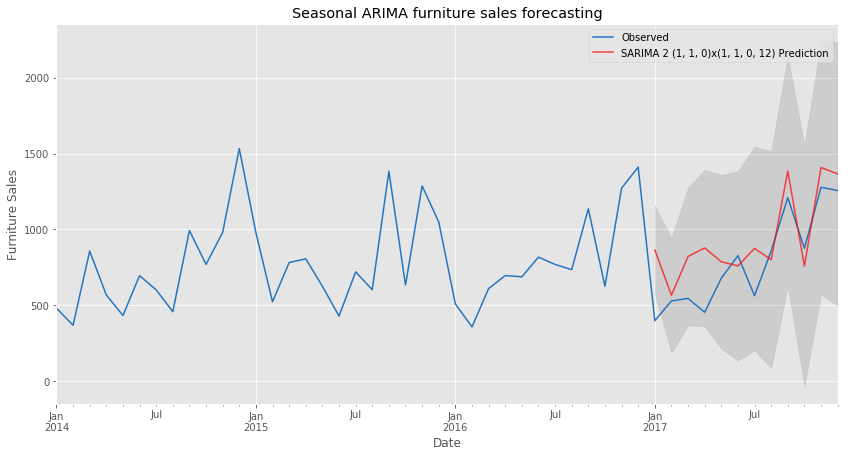

In [35]:
# One step ahead forecast
sarima_predict_2 = sarima_fit_2.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_2.predicted_mean.plot(ax=ax, label='SARIMA 2 (1, 1, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_2.index,
                #lower sales
                sarima_predict_conf_2.iloc[:, 0],
                #upper sales
                sarima_predict_conf_2.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [36]:
sarima_results2=performance(df[-12:],sarima_predict_2.predicted_mean)
sarima_results2

{'MSE': 55497.86, 'RMSE': 235.58, 'MAPE': 33.5}

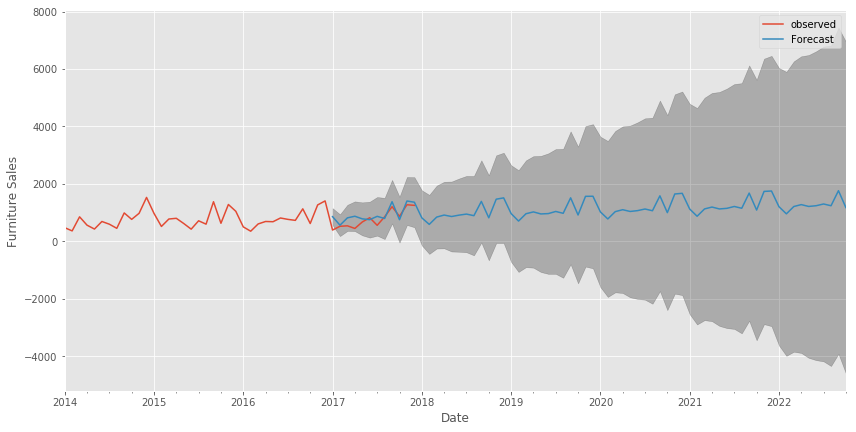

In [37]:
furthur_predict_2 = sarima_fit_2.get_forecast(steps=70)
furthur_conf_2 = furthur_predict_2.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(furthur_conf_2.index,
                furthur_conf_2.iloc[:, 0],
                furthur_conf_2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Comparison

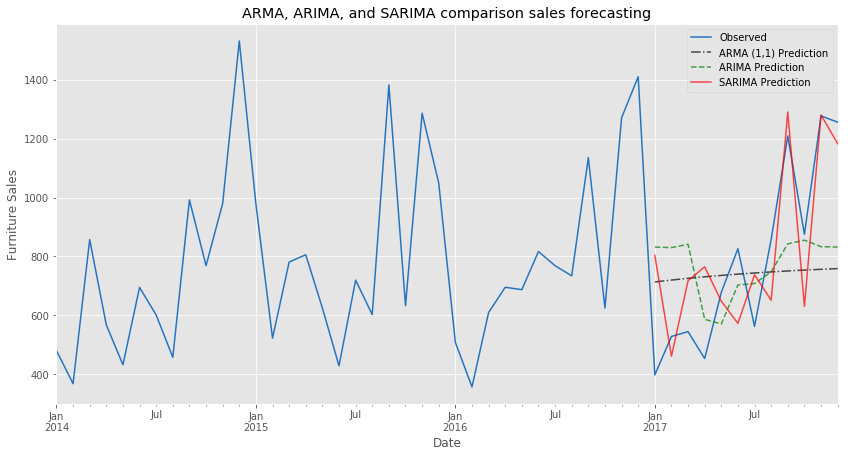

In [38]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax,label='ARMA (1,1) Prediction', linestyle= '-.', alpha= 0.7, color='k')
arima_predict.plot(ax=ax, label='ARIMA Prediction', linestyle= "--" ,alpha= 0.7, color='g')
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Prediction', alpha= 0.7, color='red') 
plt.title('ARMA, ARIMA, and SARIMA comparison sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()




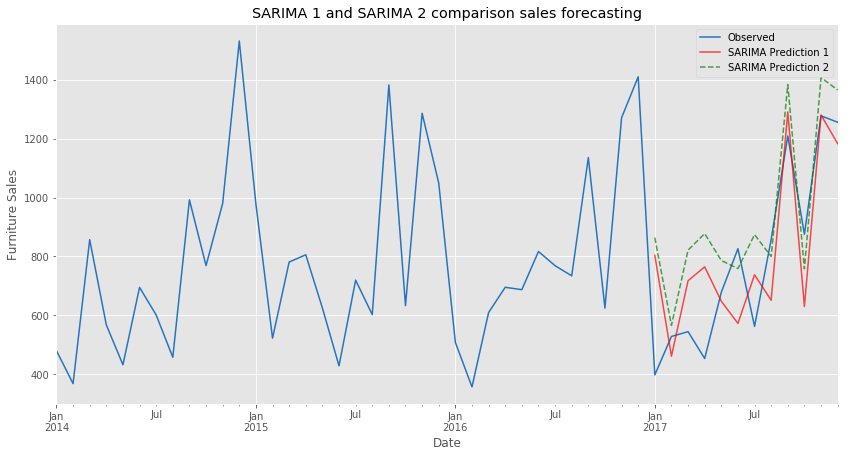

In [39]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "-", color='red') 
sarima_predict_2.predicted_mean.plot(ax=ax, label='SARIMA Prediction 2', linestyle= "--", alpha= 0.7, color='g')

plt.title('SARIMA 1 and SARIMA 2 comparison sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


## Double exponential smoothing

In [40]:
#Prediction with double exponential smoothing
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DES = ExponentialSmoothing(trainset, trend = 'add')
DES_fit = DES.fit(smoothing_level=0.5)
DES_predict = DES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

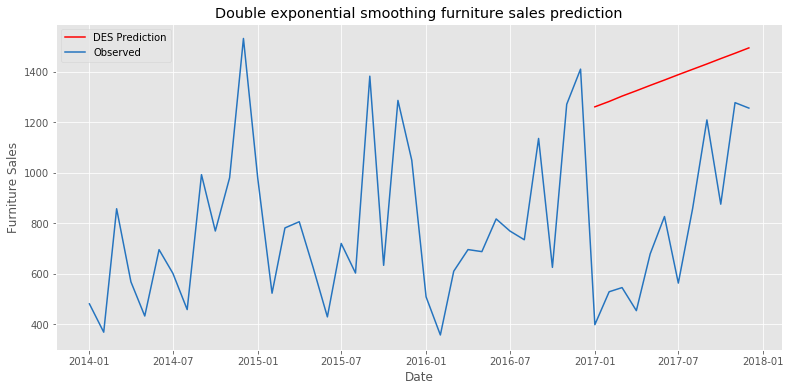

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_DES = DES_predict.values.tolist()
y = df.values.tolist()
plt.plot(DES_predict.index, yhat_DES, color='r',label='DES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double exponential smoothing furniture sales prediction')
plt.show()

In [42]:
DES_results=performance(df[-12:], yhat_DES)
DES_results

{'MSE': 404596.36, 'RMSE': 636.08, 'MAPE': 98.79}

### Triple exponential smoothing

In [43]:
#Prediction with exponential smoothing + seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing
TES = ExponentialSmoothing(trainset, trend = 'add', seasonal = 'add', seasonal_periods = 12)
TES_fit = TES.fit(smoothing_level=0.5)
TES_predict = TES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

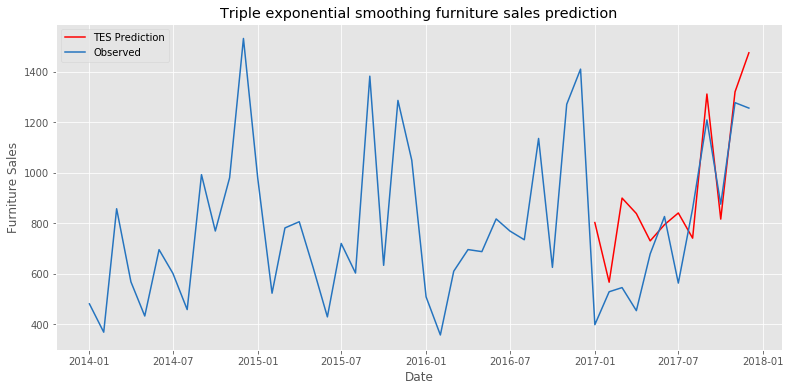

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Triple exponential smoothing furniture sales prediction')
plt.show()

In [45]:
TES_results= performance(df[-12:], yhat_TES)
TES_results

{'MSE': 49846.48, 'RMSE': 223.26, 'MAPE': 30.81}

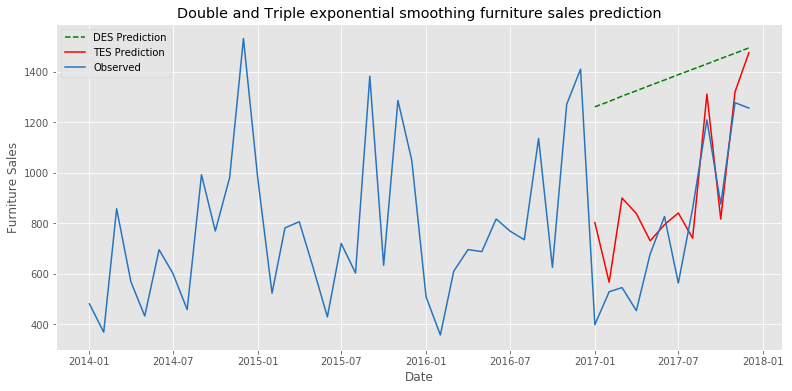

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(DES_predict.index, yhat_DES, color='g',linestyle= "--",label='DES Prediction')
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double and Triple exponential smoothing furniture sales prediction')
plt.show()

## Prophet Method

### Prophet First model

In [47]:
df_furniture_train = pd.DataFrame({'order_date':trainset.index, 'sales':trainset.values})
df_furniture_test = pd.DataFrame({'order_date':testset.index, 'sales':testset.values})

In [48]:
warnings.filterwarnings("ignore")
from fbprophet import Prophet
df_furniture_train = df_furniture_train.rename(columns={'order_date': 'ds', 'sales': 'y'})
df_furniture_test = df_furniture_test.rename(columns={'order_date': 'ds', 'sales': 'y'})

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [49]:
warnings.filterwarnings("ignore")
# set the uncertainty interval to 95% (Prophet default is 80%)
furniture_model = Prophet(interval_width=0.95, yearly_seasonality=True)
furniture_model.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1296x432 with 0 Axes>

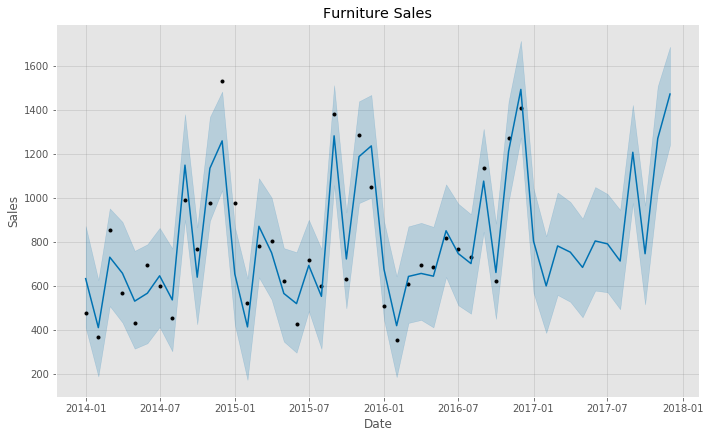

In [51]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

In [52]:
furniture_forecast.drop(columns=['multiplicative_terms', 'multiplicative_terms_lower','multiplicative_terms_upper'])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-01-01,681.588219,411.337373,873.016497,681.588219,681.588219,-47.448838,-47.448838,-47.448838,-47.448838,-47.448838,-47.448838,634.139381
1,2014-02-01,685.636335,189.751389,628.035557,685.636335,685.636335,-274.076247,-274.076247,-274.076247,-274.076247,-274.076247,-274.076247,411.560088
2,2014-03-01,689.292697,509.405296,953.310287,689.292697,689.292697,42.432009,42.432009,42.432009,42.432009,42.432009,42.432009,731.724706
3,2014-04-01,693.340812,434.650404,892.007162,693.340812,693.340812,-34.565068,-34.565068,-34.565068,-34.565068,-34.565068,-34.565068,658.775745
4,2014-05-01,697.258344,315.998944,760.663643,697.258344,697.258344,-165.311506,-165.311506,-165.311506,-165.311506,-165.311506,-165.311506,531.946837
5,2014-06-01,701.306459,340.588016,790.295510,701.306459,701.306459,-133.386474,-133.386474,-133.386474,-133.386474,-133.386474,-133.386474,567.919985
6,2014-07-01,705.223990,414.604256,864.650124,705.223990,705.223990,-58.042923,-58.042923,-58.042923,-58.042923,-58.042923,-58.042923,647.181067
7,2014-08-01,709.272106,303.993770,771.501614,709.272106,709.272106,-171.626465,-171.626465,-171.626465,-171.626465,-171.626465,-171.626465,537.645640
8,2014-09-01,713.320221,901.281186,1381.620317,713.320221,713.320221,436.759246,436.759246,436.759246,436.759246,436.759246,436.759246,1150.079467
9,2014-10-01,717.237752,426.914959,867.337459,717.237752,717.237752,-76.340818,-76.340818,-76.340818,-76.340818,-76.340818,-76.340818,640.896934


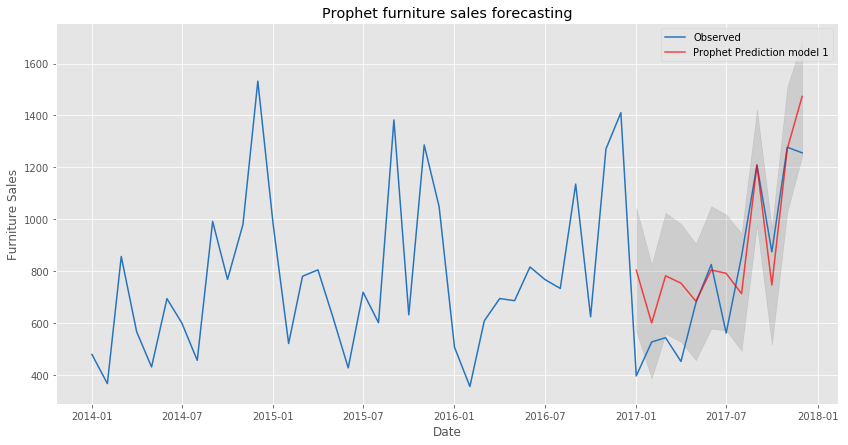

In [53]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast[36:48]['yhat'].values,label='Prophet Prediction model 1', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [54]:
prophet_results=performance(df[36:48].values, furniture_forecast[36:48]['yhat'])
prophet_results

{'MSE': 37992.52, 'RMSE': 194.92, 'MAPE': 26.67}

In [155]:
test= furniture_forecast.set_index('ds')

### Prophet Second model

In [56]:
#add holidays
new_year_holidays = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01', '2015-01-01','2016-01-01'])}) 

furniture_model2 = Prophet(yearly_seasonality=True, holidays=new_year_holidays)
furniture_model2.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
furniture_forecast2 = furniture_model2.make_future_dataframe(periods=36, freq='MS')
furniture_forecast2 = furniture_model2.predict(furniture_forecast2)

<Figure size 1296x432 with 0 Axes>

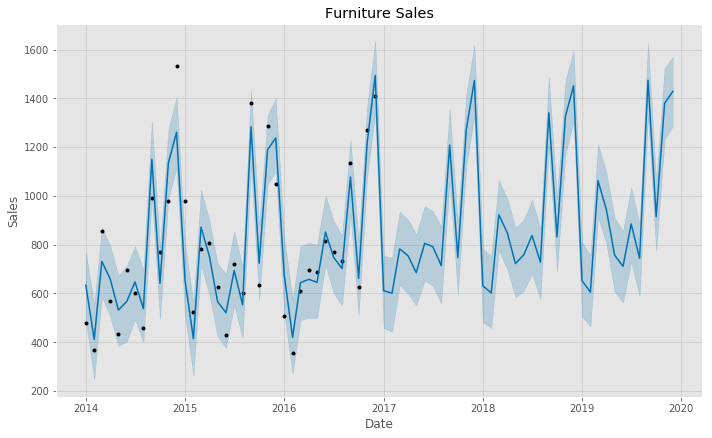

In [58]:
plt.figure(figsize=(18, 6))
furniture_model2.plot(furniture_forecast2, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

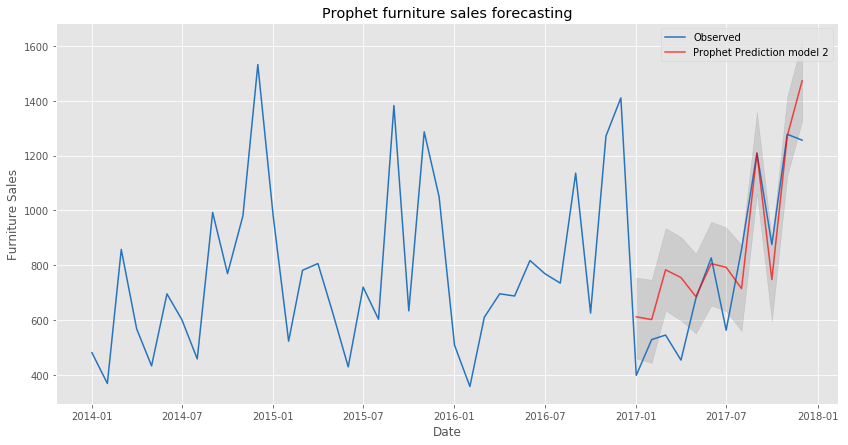

In [59]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction model 2', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast2[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast2[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [60]:
prophet_results2= performance(df[36:48].values, furniture_forecast2[36:48]['yhat'])
prophet_results

{'MSE': 37992.52, 'RMSE': 194.92, 'MAPE': 26.67}

In [156]:
test2= furniture_forecast2.set_index('ds')

## LSTM

In [62]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [63]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [64]:
n_input = 12
# Univariate
n_features = 1
# Use TimeseriesGenerator
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

### Vanilla LSTM

In [65]:
######
#set the counter 
n=20
store= np.zeros((12,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/200
3/3 [==============================] - 1s 276ms/step - loss: 0.2644
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2208
Epoch 3/200
3/3 [==============================] - 0s 27ms/step - loss: 0.1957
Epoch 4/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1654
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1421
Epoch 6/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1118
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0891
Epoch 8/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0804
Epoch 9/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0744
Epoch 10/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0786
Epoch 11/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0802
Epoch 12/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0793
Epoch 13/200
3/3 [==============================

3/3 [==============================] - 0s 35ms/step - loss: 0.0655
Epoch 104/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0651
Epoch 105/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0669
Epoch 106/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0661
Epoch 107/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0644
Epoch 108/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0642
Epoch 109/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0644
Epoch 110/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0632
Epoch 111/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0624
Epoch 112/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0620
Epoch 113/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0612
Epoch 114/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0604
Epoch 115/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.1245
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0897
Epoch 6/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0832
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0709
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0799
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0835
Epoch 10/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0807
Epoch 11/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0771
Epoch 12/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0748
Epoch 13/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0732
Epoch 14/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 15/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0739
Epoch 16/200
3/3 [==============================] - 0s 34m

3/3 [==============================] - 0s 36ms/step - loss: 0.0659
Epoch 107/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0661
Epoch 108/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0653
Epoch 109/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0669
Epoch 110/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0665
Epoch 111/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0648
Epoch 112/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0643
Epoch 113/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0651
Epoch 114/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0638
Epoch 115/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0640
Epoch 116/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0629
Epoch 117/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0625
Epoch 118/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0741
Epoch 8/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0773
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0844
Epoch 10/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0815
Epoch 11/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0772
Epoch 12/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0734
Epoch 13/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0718
Epoch 14/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0717
Epoch 15/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0742
Epoch 16/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0740
Epoch 17/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0735
Epoch 18/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0744
Epoch 19/200
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 34ms/step - loss: 0.0410
Epoch 110/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0404
Epoch 111/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0431
Epoch 112/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0465
Epoch 113/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0410
Epoch 114/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0410
Epoch 115/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0382
Epoch 116/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0367
Epoch 117/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0359
Epoch 118/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0349
Epoch 119/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0342
Epoch 120/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0333
Epoch 121/200
3/3 [=======================

3/3 [==============================] - 0s 33ms/step - loss: 0.0771
Epoch 11/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0778
Epoch 12/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0751
Epoch 13/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0737
Epoch 14/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0740
Epoch 15/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0735
Epoch 16/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0730
Epoch 17/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 18/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0745
Epoch 19/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0749
Epoch 20/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0745
Epoch 21/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0739
Epoch 22/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0366
Epoch 113/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0339
Epoch 114/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0340
Epoch 115/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0343
Epoch 116/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0323
Epoch 117/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0319
Epoch 118/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0306
Epoch 119/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0301
Epoch 120/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0305
Epoch 121/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0275
Epoch 122/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0302
Epoch 123/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0275
Epoch 124/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0743
Epoch 14/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0729
Epoch 15/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0730
Epoch 16/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0734
Epoch 17/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0730
Epoch 18/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0728
Epoch 19/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 20/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 21/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0736
Epoch 22/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0734
Epoch 23/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0732
Epoch 24/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0731
Epoch 25/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0385
Epoch 116/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0370
Epoch 117/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0377
Epoch 118/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0364
Epoch 119/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0357
Epoch 120/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0346
Epoch 121/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0338
Epoch 122/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0339
Epoch 123/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0338
Epoch 124/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0349
Epoch 125/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0314
Epoch 126/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0316
Epoch 127/200
3/3 [=======================

3/3 [==============================] - 0s 36ms/step - loss: 0.0732
Epoch 17/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0730
Epoch 18/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0725
Epoch 19/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0728
Epoch 20/200
3/3 [==============================] - 0s 92ms/step - loss: 0.0723
Epoch 21/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0729
Epoch 22/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0732
Epoch 23/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0733
Epoch 24/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0737
Epoch 25/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0732
Epoch 26/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0734
Epoch 27/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0723
Epoch 28/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0434
Epoch 119/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0414
Epoch 120/200
3/3 [==============================] - 0s 65ms/step - loss: 0.0395
Epoch 121/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0391
Epoch 122/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0380
Epoch 123/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0374
Epoch 124/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0368
Epoch 125/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0365
Epoch 126/200
3/3 [==============================] - 0s 64ms/step - loss: 0.0360
Epoch 127/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0353
Epoch 128/200
3/3 [==============================] - 0s 46ms/step - loss: 0.0351
Epoch 129/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0338
Epoch 130/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0735
Epoch 20/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0739
Epoch 21/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0742
Epoch 22/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0734
Epoch 23/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0730
Epoch 24/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0732
Epoch 25/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0737
Epoch 26/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0727
Epoch 27/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0733
Epoch 28/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0728
Epoch 29/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0732
Epoch 30/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0734
Epoch 31/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 32ms/step - loss: 0.0397
Epoch 122/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0372
Epoch 123/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0378
Epoch 124/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0385
Epoch 125/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0344
Epoch 126/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0367
Epoch 127/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0357
Epoch 128/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0369
Epoch 129/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0380
Epoch 130/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0355
Epoch 131/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0323
Epoch 132/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0313
Epoch 133/200
3/3 [=======================

3/3 [==============================] - 0s 36ms/step - loss: 0.0750
Epoch 23/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0741
Epoch 24/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0736
Epoch 25/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0732
Epoch 26/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0731
Epoch 27/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0734
Epoch 28/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0738
Epoch 29/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0731
Epoch 30/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 31/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0739
Epoch 32/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0734
Epoch 33/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0736
Epoch 34/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0354
Epoch 125/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0345
Epoch 126/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0361
Epoch 127/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0362
Epoch 128/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0359
Epoch 129/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0336
Epoch 130/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0332
Epoch 131/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0344
Epoch 132/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0331
Epoch 133/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0319
Epoch 134/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0310
Epoch 135/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0325
Epoch 136/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0736
Epoch 26/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0735
Epoch 27/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0725
Epoch 28/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0730
Epoch 29/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0723
Epoch 30/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 31/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0729
Epoch 32/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0731
Epoch 33/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0722
Epoch 34/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0727
Epoch 35/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0722
Epoch 36/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 37/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0622
Epoch 128/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0610
Epoch 129/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0600
Epoch 130/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0602
Epoch 131/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0607
Epoch 132/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0598
Epoch 133/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0586
Epoch 134/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0578
Epoch 135/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0584
Epoch 136/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0569
Epoch 137/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0590
Epoch 138/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0559
Epoch 139/200
3/3 [=======================

3/3 [==============================] - 0s 36ms/step - loss: 0.0723
Epoch 29/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0731
Epoch 30/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0732
Epoch 31/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0727
Epoch 32/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0728
Epoch 33/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0733
Epoch 34/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0727
Epoch 35/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 36/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0720
Epoch 37/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0720
Epoch 38/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0721
Epoch 39/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0723
Epoch 40/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0340
Epoch 131/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0339
Epoch 132/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0367
Epoch 133/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0332
Epoch 134/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0369
Epoch 135/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0314
Epoch 136/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0333
Epoch 137/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0326
Epoch 138/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0309
Epoch 139/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0317
Epoch 140/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0292
Epoch 141/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0310
Epoch 142/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0740
Epoch 32/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0726
Epoch 33/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0733
Epoch 34/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0725
Epoch 35/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0725
Epoch 36/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0735
Epoch 37/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0724
Epoch 38/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 39/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0729
Epoch 40/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 41/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0731
Epoch 42/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0724
Epoch 43/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 36ms/step - loss: 0.0613
Epoch 134/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0612
Epoch 135/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0601
Epoch 136/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0598
Epoch 137/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0595
Epoch 138/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0606
Epoch 139/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0592
Epoch 140/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0591
Epoch 141/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0579
Epoch 142/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0578
Epoch 143/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0576
Epoch 144/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0572
Epoch 145/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0733
Epoch 35/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0717
Epoch 36/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0722
Epoch 37/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0718
Epoch 38/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 39/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0711
Epoch 40/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0709
Epoch 41/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0710
Epoch 42/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0712
Epoch 43/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0718
Epoch 44/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0735
Epoch 45/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0734
Epoch 46/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0243
Epoch 137/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0202
Epoch 138/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0500
Epoch 139/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0232
Epoch 140/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0264
Epoch 141/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0409
Epoch 142/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0276
Epoch 143/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0310
Epoch 144/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0315
Epoch 145/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0316
Epoch 146/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0319
Epoch 147/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0274
Epoch 148/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0723
Epoch 38/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0727
Epoch 39/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 40/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0728
Epoch 41/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 42/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0724
Epoch 43/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0720
Epoch 44/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0719
Epoch 45/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 46/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0718
Epoch 47/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0723
Epoch 48/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0718
Epoch 49/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 24ms/step - loss: 0.0394
Epoch 140/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0403
Epoch 141/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0403
Epoch 142/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0411
Epoch 143/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0399
Epoch 144/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0377
Epoch 145/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0373
Epoch 146/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0377
Epoch 147/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0376
Epoch 148/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0362
Epoch 149/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0364
Epoch 150/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0352
Epoch 151/200
3/3 [=======================

Epoch 41/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0717
Epoch 42/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0721
Epoch 43/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0716
Epoch 44/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0720
Epoch 45/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 46/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0711
Epoch 47/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0719
Epoch 48/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0710
Epoch 49/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0708
Epoch 50/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0709
Epoch 51/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0712
Epoch 52/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0708
Epoch 53/200
3/3 [======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0242
Epoch 143/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0260
Epoch 144/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0233
Epoch 145/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0250
Epoch 146/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0236
Epoch 147/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0238
Epoch 148/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0224
Epoch 149/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0237
Epoch 150/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0218
Epoch 151/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0232
Epoch 152/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0220
Epoch 153/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0222
Epoch 154/200
3/3 [=======================

Epoch 44/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0719
Epoch 45/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0723
Epoch 46/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0719
Epoch 47/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0717
Epoch 48/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0716
Epoch 49/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0716
Epoch 50/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0718
Epoch 51/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0719
Epoch 52/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0724
Epoch 53/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0722
Epoch 54/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0727
Epoch 55/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0720
Epoch 56/200
3/3 [======================

3/3 [==============================] - 0s 37ms/step - loss: 0.0424
Epoch 146/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0389
Epoch 147/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0418
Epoch 148/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0363
Epoch 149/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0366
Epoch 150/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0370
Epoch 151/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0356
Epoch 152/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0348
Epoch 153/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0346
Epoch 154/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0344
Epoch 155/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0349
Epoch 156/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0321
Epoch 157/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 47/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 48/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0722
Epoch 49/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0722
Epoch 50/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0722
Epoch 51/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0727
Epoch 52/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0721
Epoch 53/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0723
Epoch 54/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0718
Epoch 55/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0715
Epoch 56/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0726
Epoch 57/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0725
Epoch 58/200
3/3 [==============================] - 0

Epoch 148/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0587
Epoch 149/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0581
Epoch 150/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0547
Epoch 151/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0544
Epoch 152/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0552
Epoch 153/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0564
Epoch 154/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0555
Epoch 155/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0538
Epoch 156/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0548
Epoch 157/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0535
Epoch 158/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0525
Epoch 159/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0516
Epoch 160/200
3/3 [=========

3/3 [==============================] - 0s 36ms/step - loss: 0.0721
Epoch 50/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0726
Epoch 51/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0720
Epoch 52/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0717
Epoch 53/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0715
Epoch 54/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0713
Epoch 55/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 56/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0715
Epoch 57/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 58/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0720
Epoch 59/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0722
Epoch 60/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0717
Epoch 61/200
3/3 [==============================] - 0

Epoch 151/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0441
Epoch 152/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0403
Epoch 153/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0459
Epoch 154/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0428
Epoch 155/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0460
Epoch 156/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0384
Epoch 157/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0433
Epoch 158/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0380
Epoch 159/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0433
Epoch 160/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0376
Epoch 161/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0398
Epoch 162/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0409
Epoch 163/200
3/3 [=========

3/3 [==============================] - 0s 33ms/step - loss: 0.0713
Epoch 53/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0724
Epoch 54/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 55/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 56/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0723
Epoch 57/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 58/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0708
Epoch 59/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0711
Epoch 60/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0710
Epoch 61/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0715
Epoch 62/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0708
Epoch 63/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0702
Epoch 64/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 32ms/step - loss: 0.0181
Epoch 154/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0169
Epoch 155/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0170
Epoch 156/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0149
Epoch 157/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0150
Epoch 158/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0139
Epoch 159/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0141
Epoch 160/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0135
Epoch 161/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0122
Epoch 162/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0116
Epoch 163/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0114
Epoch 164/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0114
Epoch 165/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0721
Epoch 56/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0721
Epoch 57/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 58/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0721
Epoch 59/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0725
Epoch 60/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0718
Epoch 61/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0715
Epoch 62/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0711
Epoch 63/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0723
Epoch 64/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0712
Epoch 65/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0712
Epoch 66/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 67/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0550
Epoch 157/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0547
Epoch 158/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0550
Epoch 159/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0542
Epoch 160/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0540
Epoch 161/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0540
Epoch 162/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0534
Epoch 163/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0536
Epoch 164/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0532
Epoch 165/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0529
Epoch 166/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0525
Epoch 167/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0517
Epoch 168/200
3/3 [=======================

3/3 [==============================] - 0s 36ms/step - loss: 0.0709
Epoch 59/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0711
Epoch 60/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0707
Epoch 61/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0711
Epoch 62/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0710
Epoch 63/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0714
Epoch 64/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0708
Epoch 65/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0705
Epoch 66/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0703
Epoch 67/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0713
Epoch 68/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0714
Epoch 69/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0706
Epoch 70/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0196
Epoch 160/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0184
Epoch 161/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0139
Epoch 162/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0167
Epoch 163/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0171
Epoch 164/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0158
Epoch 165/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0152
Epoch 166/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0130
Epoch 167/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0136
Epoch 168/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0145
Epoch 169/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0164
Epoch 170/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0115
Epoch 171/200
3/3 [=======================

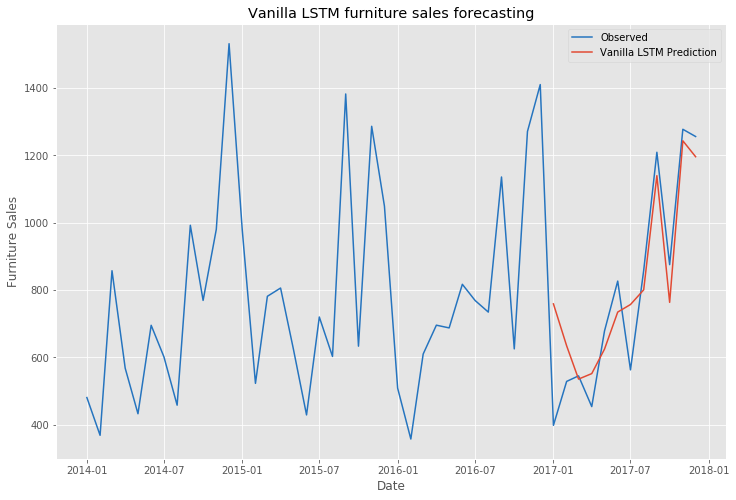

In [67]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [66]:
final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((12,))


vanilla_lstm= performance(df[-12:],final_vanilla)
vanilla_lstm

{'MSE': 18829.66, 'RMSE': 137.22, 'MAPE': 18.39}

### Stacked LSTM

In [68]:
######
n=20
store2= np.zeros((12,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    model_stacked.add(LSTM(50, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(50, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200
3/3 [==============================] - 4s 1s/step - loss: 0.2453
Epoch 2/200
3/3 [==============================] - 0s 29ms/step - loss: 0.2220
Epoch 3/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1994
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1706
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1453
Epoch 6/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1096
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0824
Epoch 8/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0845
Epoch 9/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0834
Epoch 10/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0822
Epoch 11/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0756
Epoch 12/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0734
Epoch 13/200
3/3 [==============================] -

3/3 [==============================] - 0s 30ms/step - loss: 0.0356
Epoch 104/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0371
Epoch 105/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0497
Epoch 106/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0496
Epoch 107/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0399
Epoch 108/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0395
Epoch 109/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0339
Epoch 110/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0409
Epoch 111/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0368
Epoch 112/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0362
Epoch 113/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0367
Epoch 114/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0340
Epoch 115/200
3/3 [=======================

3/3 [==============================] - 0s 37ms/step - loss: 0.1472
Epoch 5/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1199
Epoch 6/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0863
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0847
Epoch 8/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0922
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0882
Epoch 10/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0797
Epoch 11/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0748
Epoch 12/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0764
Epoch 13/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0766
Epoch 14/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0761
Epoch 15/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0751
Epoch 16/200
3/3 [==============================] - 0s 32m

3/3 [==============================] - 0s 35ms/step - loss: 0.0459
Epoch 107/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0465
Epoch 108/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0447
Epoch 109/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0441
Epoch 110/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0456
Epoch 111/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0440
Epoch 112/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0432
Epoch 113/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0431
Epoch 114/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0430
Epoch 115/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0425
Epoch 116/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0416
Epoch 117/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0419
Epoch 118/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0808
Epoch 8/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0749
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0819
Epoch 10/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0831
Epoch 11/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0794
Epoch 12/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0757
Epoch 13/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0734
Epoch 14/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0733
Epoch 15/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0745
Epoch 16/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0745
Epoch 17/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0731
Epoch 18/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0726
Epoch 19/200
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 32ms/step - loss: 0.0323
Epoch 110/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0329
Epoch 111/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0319
Epoch 112/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0321
Epoch 113/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0316
Epoch 114/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0315
Epoch 115/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0311
Epoch 116/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0308
Epoch 117/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0308
Epoch 118/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0314
Epoch 119/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0303
Epoch 120/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0315
Epoch 121/200
3/3 [=======================

3/3 [==============================] - 0s 32ms/step - loss: 0.0809
Epoch 11/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0773
Epoch 12/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 13/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0736
Epoch 14/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0751
Epoch 15/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0748
Epoch 16/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0743
Epoch 17/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0749
Epoch 18/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0747
Epoch 19/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 20/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0739
Epoch 21/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0739
Epoch 22/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0332
Epoch 113/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0295
Epoch 114/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0305
Epoch 115/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0303
Epoch 116/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0304
Epoch 117/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0299
Epoch 118/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0260
Epoch 119/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0244
Epoch 120/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0289
Epoch 121/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0251
Epoch 122/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0293
Epoch 123/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0347
Epoch 124/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0736
Epoch 14/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0737
Epoch 15/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0735
Epoch 16/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0734
Epoch 17/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0742
Epoch 18/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0734
Epoch 19/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0738
Epoch 20/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0742
Epoch 21/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0742
Epoch 22/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0741
Epoch 23/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0738
Epoch 24/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0734
Epoch 25/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 36ms/step - loss: 0.0236
Epoch 116/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0262
Epoch 117/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0355
Epoch 118/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0199
Epoch 119/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0206
Epoch 120/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0261
Epoch 121/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0190
Epoch 122/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0220
Epoch 123/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0194
Epoch 124/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0187
Epoch 125/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0168
Epoch 126/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0377
Epoch 127/200
3/3 [=======================

3/3 [==============================] - 0s 32ms/step - loss: 0.0729
Epoch 17/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0730
Epoch 18/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0748
Epoch 19/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0738
Epoch 20/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0739
Epoch 21/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0737
Epoch 22/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0742
Epoch 23/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0735
Epoch 24/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0735
Epoch 25/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 26/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0736
Epoch 27/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0736
Epoch 28/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0385
Epoch 119/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0402
Epoch 120/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0373
Epoch 121/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0370
Epoch 122/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0388
Epoch 123/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0351
Epoch 124/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0354
Epoch 125/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0334
Epoch 126/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0327
Epoch 127/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0322
Epoch 128/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0312
Epoch 129/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0312
Epoch 130/200
3/3 [=======================

3/3 [==============================] - 0s 30ms/step - loss: 0.0731
Epoch 20/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0731
Epoch 21/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0751
Epoch 22/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0741
Epoch 23/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0739
Epoch 24/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0745
Epoch 25/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0735
Epoch 26/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0739
Epoch 27/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0729
Epoch 28/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0736
Epoch 29/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0736
Epoch 30/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0738
Epoch 31/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 33ms/step - loss: 0.0395
Epoch 122/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0378
Epoch 123/200
3/3 [==============================] - 0s 71ms/step - loss: 0.0372
Epoch 124/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0372
Epoch 125/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0394
Epoch 126/200
3/3 [==============================] - 0s 70ms/step - loss: 0.0392
Epoch 127/200
3/3 [==============================] - 0s 59ms/step - loss: 0.0373
Epoch 128/200
3/3 [==============================] - 0s 46ms/step - loss: 0.0342
Epoch 129/200
3/3 [==============================] - 0s 65ms/step - loss: 0.0402
Epoch 130/200
3/3 [==============================] - 0s 66ms/step - loss: 0.0382
Epoch 131/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0375
Epoch 132/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0426
Epoch 133/200
3/3 [=======================

3/3 [==============================] - 0s 40ms/step - loss: 0.0731
Epoch 23/200
3/3 [==============================] - 0s 59ms/step - loss: 0.0742
Epoch 24/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0740
Epoch 25/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0735
Epoch 26/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0731
Epoch 27/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0727
Epoch 28/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 29/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0734
Epoch 30/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 31/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0725
Epoch 32/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0739
Epoch 33/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0728
Epoch 34/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0357
Epoch 125/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0346
Epoch 126/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0275
Epoch 127/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0223
Epoch 128/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0233
Epoch 129/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0184
Epoch 130/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0183
Epoch 131/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0170
Epoch 132/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0180
Epoch 133/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0164
Epoch 134/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0150
Epoch 135/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0148
Epoch 136/200
3/3 [=======================

3/3 [==============================] - 0s 31ms/step - loss: 0.0729
Epoch 26/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 27/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0727
Epoch 28/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0727
Epoch 29/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0726
Epoch 30/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0732
Epoch 31/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0732
Epoch 32/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0727
Epoch 33/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0724
Epoch 34/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0721
Epoch 35/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0724
Epoch 36/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0725
Epoch 37/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 31ms/step - loss: 0.0312
Epoch 128/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0362
Epoch 129/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0190
Epoch 130/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0205
Epoch 131/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0179
Epoch 132/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0188
Epoch 133/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0175
Epoch 134/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0165
Epoch 135/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0175
Epoch 136/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0144
Epoch 137/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0164
Epoch 138/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0165
Epoch 139/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 29/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0734
Epoch 30/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0730
Epoch 31/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0726
Epoch 32/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0739
Epoch 33/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0740
Epoch 34/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0742
Epoch 35/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0739
Epoch 36/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0733
Epoch 37/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0728
Epoch 38/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0738
Epoch 39/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0726
Epoch 40/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 35ms/step - loss: 0.0392
Epoch 131/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0381
Epoch 132/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0368
Epoch 133/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0362
Epoch 134/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0365
Epoch 135/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0335
Epoch 136/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0348
Epoch 137/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0300
Epoch 138/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0288
Epoch 139/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0259
Epoch 140/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0261
Epoch 141/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0237
Epoch 142/200
3/3 [=======================

3/3 [==============================] - 0s 33ms/step - loss: 0.0739
Epoch 32/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0732
Epoch 33/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0732
Epoch 34/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0732
Epoch 35/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0737
Epoch 36/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0732
Epoch 37/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0736
Epoch 38/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0737
Epoch 39/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0736
Epoch 40/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0733
Epoch 41/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0728
Epoch 42/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0724
Epoch 43/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 37ms/step - loss: 0.0362
Epoch 134/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0355
Epoch 135/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0354
Epoch 136/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0320
Epoch 137/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0315
Epoch 138/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0311
Epoch 139/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0313
Epoch 140/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0300
Epoch 141/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0308
Epoch 142/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0300
Epoch 143/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0299
Epoch 144/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0295
Epoch 145/200
3/3 [=======================

3/3 [==============================] - 0s 32ms/step - loss: 0.0739
Epoch 35/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 36/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0737
Epoch 37/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0731
Epoch 38/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0736
Epoch 39/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0728
Epoch 40/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0737
Epoch 41/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0737
Epoch 42/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0736
Epoch 43/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0733
Epoch 44/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0729
Epoch 45/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0741
Epoch 46/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 33ms/step - loss: 0.0367
Epoch 137/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0340
Epoch 138/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0339
Epoch 139/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0385
Epoch 140/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0353
Epoch 141/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0436
Epoch 142/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0334
Epoch 143/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0335
Epoch 144/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0340
Epoch 145/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0317
Epoch 146/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0321
Epoch 147/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0314
Epoch 148/200
3/3 [=======================

3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 38/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0725
Epoch 39/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0724
Epoch 40/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0724
Epoch 41/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0732
Epoch 42/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0731
Epoch 43/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0722
Epoch 44/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0722
Epoch 45/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0721
Epoch 46/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0730
Epoch 47/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0722
Epoch 48/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0719
Epoch 49/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 36ms/step - loss: 0.0264
Epoch 140/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0259
Epoch 141/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0282
Epoch 142/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0226
Epoch 143/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0248
Epoch 144/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0244
Epoch 145/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0279
Epoch 146/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0272
Epoch 147/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0226
Epoch 148/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0260
Epoch 149/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0214
Epoch 150/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0242
Epoch 151/200
3/3 [=======================

Epoch 41/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 42/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0726
Epoch 43/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0728
Epoch 44/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0726
Epoch 45/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0741
Epoch 46/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0737
Epoch 47/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0734
Epoch 48/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0735
Epoch 49/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0727
Epoch 50/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0721
Epoch 51/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 52/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0720
Epoch 53/200
3/3 [======================

3/3 [==============================] - 0s 32ms/step - loss: 0.0208
Epoch 143/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0226
Epoch 144/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0187
Epoch 145/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0215
Epoch 146/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0247
Epoch 147/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0254
Epoch 148/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0205
Epoch 149/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0242
Epoch 150/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0192
Epoch 151/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0213
Epoch 152/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0268
Epoch 153/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0195
Epoch 154/200
3/3 [=======================

Epoch 44/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0738
Epoch 45/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0731
Epoch 46/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0728
Epoch 47/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 48/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0734
Epoch 49/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0724
Epoch 50/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0725
Epoch 51/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0723
Epoch 52/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 53/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0725
Epoch 54/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0737
Epoch 55/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0736
Epoch 56/200
3/3 [======================

3/3 [==============================] - 0s 32ms/step - loss: 0.0502
Epoch 146/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0478
Epoch 147/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0264
Epoch 148/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0343
Epoch 149/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0292
Epoch 150/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0287
Epoch 151/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0312
Epoch 152/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0301
Epoch 153/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0272
Epoch 154/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0246
Epoch 155/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0243
Epoch 156/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0229
Epoch 157/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0723
Epoch 48/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0727
Epoch 49/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0730
Epoch 50/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0727
Epoch 51/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 52/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0729
Epoch 53/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0724
Epoch 54/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0721
Epoch 55/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0720
Epoch 56/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0724
Epoch 57/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0720
Epoch 58/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0727
Epoch 59/200
3/3 [==============================] - 0

Epoch 149/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0352
Epoch 150/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0344
Epoch 151/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0333
Epoch 152/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0333
Epoch 153/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0334
Epoch 154/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0321
Epoch 155/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0339
Epoch 156/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0324
Epoch 157/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0319
Epoch 158/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0314
Epoch 159/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0312
Epoch 160/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0318
Epoch 161/200
3/3 [=========

3/3 [==============================] - 0s 34ms/step - loss: 0.0733
Epoch 51/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0734
Epoch 52/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0727
Epoch 53/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0724
Epoch 54/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0729
Epoch 55/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0724
Epoch 56/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0730
Epoch 57/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0731
Epoch 58/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0729
Epoch 59/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0718
Epoch 60/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0723
Epoch 61/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0716
Epoch 62/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 34ms/step - loss: 0.0298
Epoch 152/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0297
Epoch 153/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0319
Epoch 154/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0308
Epoch 155/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0282
Epoch 156/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0300
Epoch 157/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0305
Epoch 158/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0282
Epoch 159/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0281
Epoch 160/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0285
Epoch 161/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0270
Epoch 162/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0267
Epoch 163/200
3/3 [=======================

3/3 [==============================] - 0s 35ms/step - loss: 0.0733
Epoch 54/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0729
Epoch 55/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0728
Epoch 56/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0725
Epoch 57/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0729
Epoch 58/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0732
Epoch 59/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0746
Epoch 60/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0743
Epoch 61/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0737
Epoch 62/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0747
Epoch 63/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0727
Epoch 64/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 65/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 33ms/step - loss: 0.0338
Epoch 155/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0345
Epoch 156/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0324
Epoch 157/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0353
Epoch 158/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0346
Epoch 159/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0327
Epoch 160/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0307
Epoch 161/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0305
Epoch 162/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0306
Epoch 163/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0300
Epoch 164/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0311
Epoch 165/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0305
Epoch 166/200
3/3 [=======================

3/3 [==============================] - 0s 37ms/step - loss: 0.0691
Epoch 57/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0708
Epoch 58/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0697
Epoch 59/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0686
Epoch 60/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0702
Epoch 61/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0703
Epoch 62/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0684
Epoch 63/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0674
Epoch 64/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0665
Epoch 65/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0659
Epoch 66/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0664
Epoch 67/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0660
Epoch 68/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 36ms/step - loss: 0.0290
Epoch 158/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0307
Epoch 159/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0299
Epoch 160/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0287
Epoch 161/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0291
Epoch 162/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0279
Epoch 163/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0276
Epoch 164/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0280
Epoch 165/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0280
Epoch 166/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0284
Epoch 167/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0272
Epoch 168/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0269
Epoch 169/200
3/3 [=======================

3/3 [==============================] - 0s 34ms/step - loss: 0.0728
Epoch 60/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0719
Epoch 61/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0726
Epoch 62/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 63/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0718
Epoch 64/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0725
Epoch 65/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0718
Epoch 66/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0712
Epoch 67/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0709
Epoch 68/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0710
Epoch 69/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0709
Epoch 70/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0725
Epoch 71/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 36ms/step - loss: 0.0167
Epoch 161/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0131
Epoch 162/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0135
Epoch 163/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0131
Epoch 164/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0129
Epoch 165/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0124
Epoch 166/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0124
Epoch 167/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0119
Epoch 168/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0121
Epoch 169/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0118
Epoch 170/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0115
Epoch 171/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0112
Epoch 172/200
3/3 [=======================

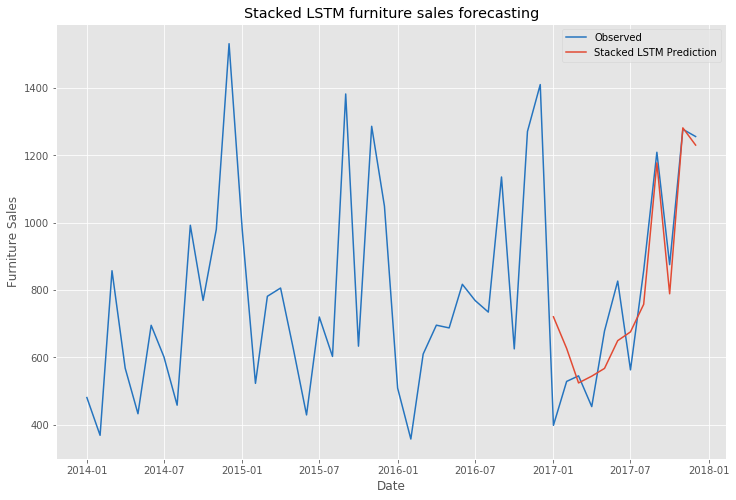

In [70]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [69]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((12,))

stacked_lstm= performance(df[-12:],final_stacked2)
stacked_lstm

{'MSE': 16515.49, 'RMSE': 128.51, 'MAPE': 17.34}

### Bidirectional LSTM

In [88]:
# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [89]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 9s 3s/step - loss: 0.2123
Epoch 2/200
3/3 [==============================] - 0s 29ms/step - loss: 0.1797
Epoch 3/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1511
Epoch 4/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1314
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1050
Epoch 6/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0928
Epoch 7/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0737
Epoch 8/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0745
Epoch 9/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0742
Epoch 10/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0737
Epoch 11/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0750
Epoch 12/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0727
Epoch 13/200
3/3 [==============================] -

3/3 [==============================] - 0s 31ms/step - loss: 0.0427
Epoch 104/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0428
Epoch 105/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0429
Epoch 106/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0423
Epoch 107/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0410
Epoch 108/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0399
Epoch 109/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0393
Epoch 110/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0380
Epoch 111/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0377
Epoch 112/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0383
Epoch 113/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0369
Epoch 114/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0367
Epoch 115/200
3/3 [=======================

In [90]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

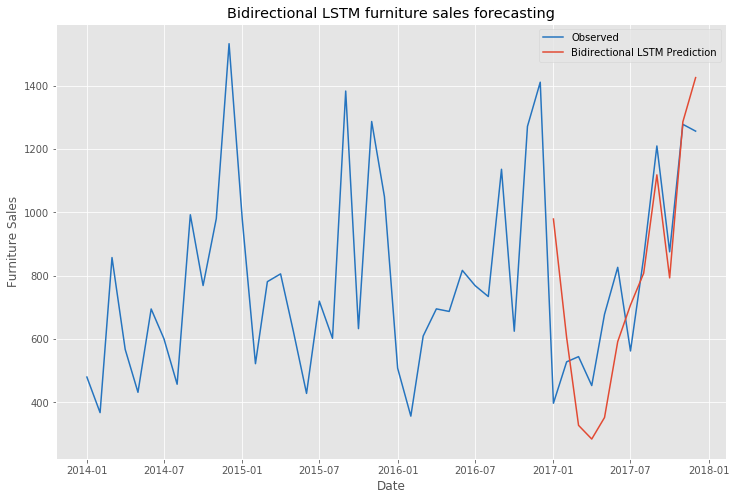

In [91]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [92]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 53981.32, 'RMSE': 232.34, 'MAPE': 31.4}

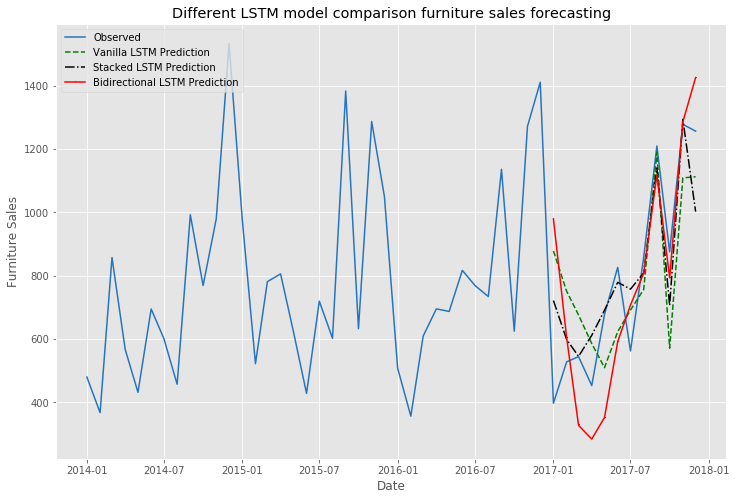

In [93]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

### LSTM model 1

In [94]:
X = df.values

In [95]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [96]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [97]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [98]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [99]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [100]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [101]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [102]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [103]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/5
35/35 [==============================] - 9s 270ms/step - loss: 0.2219
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2190
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2164
Epoch 4/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2138
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2114
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2081
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2066
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2042
Epoch 4/5
35/35 [==============================] - 0s 5ms/step - loss: 0.2019
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1996
Epoch 1/5
35/35 [==============================] - 0s 6ms/step - loss: 0.1953
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1954
Epoch 3/5
35/35 [==============================] - 0s 5ms/step

35/35 [==============================] - 0s 5ms/step - loss: 0.1459
Epoch 2/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1626
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1621
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1618
Epoch 5/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1615
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1451
Epoch 2/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1616
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1610
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1607
Epoch 5/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1604
Epoch 1/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1605
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1

35/35 [==============================] - 0s 9ms/step - loss: 0.1379
Epoch 2/5
35/35 [==============================] - 0s 7ms/step - loss: 0.1461
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1458
Epoch 4/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1458
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1457
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1379
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1458
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1455
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1455
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1454
Epoch 1/5
35/35 [==============================] - 0s 8ms/step - loss: 0.1380
Epoch 2/5
35/35 [==============================] - 0s 6ms/step - loss: 0.1455
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1

35/35 [==============================] - 0s 5ms/step - loss: 0.1414
Epoch 2/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1418
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1413
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1413
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1412
Epoch 1/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1415
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1416
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1411
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1411
Epoch 5/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1410
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1416
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1414
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1

35/35 [==============================] - 0s 5ms/step - loss: 0.1410
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1378
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1371
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1369
Epoch 5/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1368
Epoch 1/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1409
Epoch 2/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1376
Epoch 3/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1368
Epoch 4/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1366
Epoch 5/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1365
Epoch 1/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1407
Epoch 2/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1373
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1

array([[-0.23047262],
       [-0.08266111],
       [-0.5613131 ],
       [-0.30999243],
       [-0.07068446],
       [-0.21015504],
       [-0.02912093],
       [ 0.17064391],
       [-0.254512  ],
       [ 0.06471244],
       [-0.06913703],
       [-0.5031469 ],
       [-0.00589462],
       [ 0.3941316 ],
       [ 0.04703847],
       [ 0.09619883],
       [ 0.35565925],
       [ 0.54137844],
       [ 0.11954044],
       [ 0.392614  ],
       [-0.48759383],
       [ 0.28569365],
       [-0.6290627 ],
       [-0.44095474],
       [ 0.12297036],
       [ 0.3113261 ],
       [ 0.00509024],
       [-0.01655255],
       [ 0.09003749],
       [ 0.02893402],
       [ 0.18234931],
       [ 0.28088892],
       [-0.1388306 ],
       [ 0.45151687],
       [-0.3742966 ]], dtype=float32)

In [104]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [105]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=1029.998141, Expected=1410.719808
Month=2, Predicted=589.142245, Expected=397.602133
Month=3, Predicted=551.464726, Expected=528.179800
Month=4, Predicted=608.583715, Expected=544.672240
Month=5, Predicted=660.358869, Expected=453.297905
Month=6, Predicted=697.176422, Expected=678.302328
Month=7, Predicted=778.016871, Expected=826.460291
Month=8, Predicted=798.324176, Expected=562.524857
Month=9, Predicted=835.134145, Expected=857.881889
Month=10, Predicted=923.776950, Expected=1209.508583
Month=11, Predicted=907.176660, Expected=875.362728
Month=12, Predicted=1034.123375, Expected=1277.817759


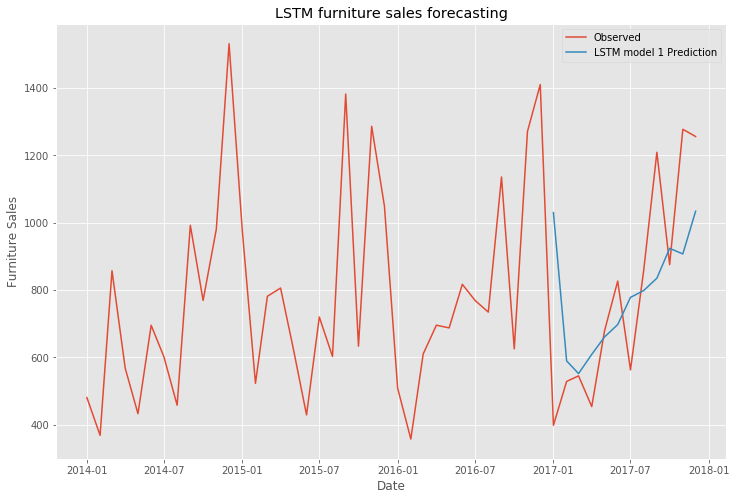

In [106]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [107]:
lstm1= performance(raw_values[-12:], predictions_lstm1)
lstm1

{'MSE': 68671.5, 'RMSE': 262.05, 'MAPE': 29.4}

Source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

### Convolutional Neural Network

In [147]:
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [148]:
#Set the timestep
timestep = 12

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)

#Set the trainset
Xtrain = X[:24,:,:]  
Ytrain = Y[:24] 

#Set the testset
Xtest = X[24:,:,:]  
Ytest= Y[24:]

In [149]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')


# fit model
cnn_model.fit(Xtrain, Ytrain, epochs=200, verbose=1) 

Epoch 1/200
24/24 [==============================] - 9s 383ms/step - loss: 0.2168
Epoch 2/200
24/24 [==============================] - 0s 336us/step - loss: 0.1439
Epoch 3/200
24/24 [==============================] - 0s 412us/step - loss: 0.1024
Epoch 4/200
24/24 [==============================] - 0s 638us/step - loss: 0.0780
Epoch 5/200
24/24 [==============================] - 0s 554us/step - loss: 0.0819
Epoch 6/200
24/24 [==============================] - 0s 442us/step - loss: 0.0949
Epoch 7/200
24/24 [==============================] - 0s 811us/step - loss: 0.0891
Epoch 8/200
24/24 [==============================] - 0s 436us/step - loss: 0.0764
Epoch 9/200
24/24 [==============================] - 0s 828us/step - loss: 0.0680
Epoch 10/200
24/24 [==============================] - 0s 443us/step - loss: 0.0665
Epoch 11/200
24/24 [==============================] - 0s 770us/step - loss: 0.0684
Epoch 12/200
24/24 [==============================] - 0s 464us/step - loss: 0.0697
Epoch 13/200


Epoch 99/200
24/24 [==============================] - 0s 334us/step - loss: 1.6416e-05
Epoch 100/200
24/24 [==============================] - 0s 525us/step - loss: 1.3188e-05
Epoch 101/200
24/24 [==============================] - 0s 497us/step - loss: 1.2528e-05
Epoch 102/200
24/24 [==============================] - 0s 529us/step - loss: 1.1945e-05
Epoch 103/200
24/24 [==============================] - 0s 458us/step - loss: 9.7039e-06
Epoch 104/200
24/24 [==============================] - 0s 464us/step - loss: 8.0184e-06
Epoch 105/200
24/24 [==============================] - 0s 487us/step - loss: 7.0223e-06
Epoch 106/200
24/24 [==============================] - 0s 430us/step - loss: 5.6409e-06
Epoch 107/200
24/24 [==============================] - 0s 469us/step - loss: 4.8483e-06
Epoch 108/200
24/24 [==============================] - 0s 498us/step - loss: 4.9488e-06
Epoch 109/200
24/24 [==============================] - 0s 476us/step - loss: 4.6889e-06
Epoch 110/200
24/24 [============

24/24 [==============================] - 0s 420us/step - loss: 2.1372e-04
Epoch 193/200
24/24 [==============================] - 0s 426us/step - loss: 1.4733e-04
Epoch 194/200
24/24 [==============================] - 0s 440us/step - loss: 4.9219e-05
Epoch 195/200
24/24 [==============================] - 0s 473us/step - loss: 4.2972e-07
Epoch 196/200
24/24 [==============================] - 0s 412us/step - loss: 2.8917e-05
Epoch 197/200
24/24 [==============================] - 0s 499us/step - loss: 8.5909e-05
Epoch 198/200
24/24 [==============================] - 0s 456us/step - loss: 1.0364e-04
Epoch 199/200
24/24 [==============================] - 0s 430us/step - loss: 6.2021e-05
Epoch 200/200
24/24 [==============================] - 0s 451us/step - loss: 1.0940e-05


In [150]:
# Validate data
preds = cnn_model.predict(Xtest)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)


In [151]:
cnn= performance(Ytest,preds)
cnn_predict= preds.reshape((12,))
cnn

{'MSE': 39938.47, 'RMSE': 199.85, 'MAPE': 22.26}

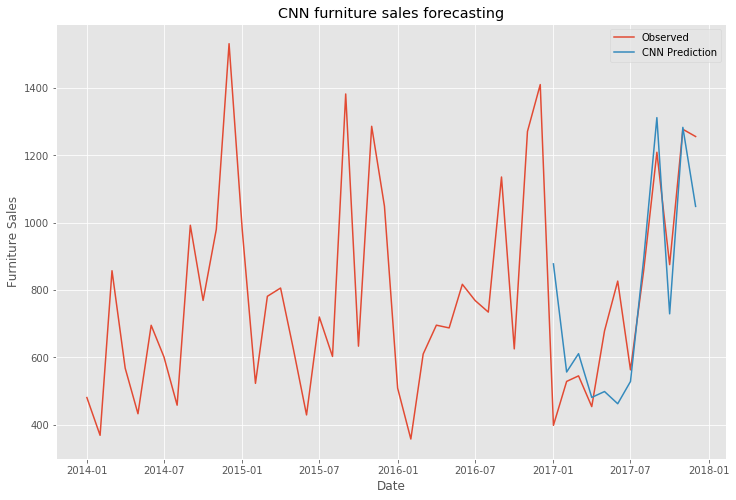

In [152]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,preds,label="CNN Prediction")
plt.title('CNN furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

## Results:

In [153]:
# intialise data of lists. 
prediction_data = {'Model':['ARMA','ARIMA','SARIMA 1','SARIMA 2','DES','TES','Prophet1','Prophet2',
                           'Vanilla LSTM','Stacked LSTM','Bidirectional LSTM','LSTM 1','CNN'],
                   
                    'MSE':[arma_results['MSE'],arima_results['MSE'],sarima_results['MSE'],sarima_results2['MSE'], 
                           DES_results['MSE'],TES_results['MSE'],prophet_results['MSE'],prophet_results2['MSE'],
                           vanilla_lstm['MSE'],stacked_lstm['MSE'],bi_lstm['MSE'],lstm1['MSE'],cnn['MSE']
                          ],
                  'RMSE':[arma_results['RMSE'],arima_results['RMSE'],sarima_results['RMSE'],sarima_results2['RMSE'], 
                          DES_results['RMSE'],TES_results['RMSE'],prophet_results['RMSE'],prophet_results2['RMSE'],
                          vanilla_lstm['RMSE'],stacked_lstm['RMSE'],bi_lstm['RMSE'],lstm1['RMSE'],cnn['RMSE']
                         ],
                  'MAPE':[arma_results['MAPE'],arima_results['MAPE'],sarima_results['MAPE'],sarima_results2['MAPE'],
                          DES_results['MAPE'],TES_results['MAPE'],prophet_results['MAPE'],prophet_results2['MAPE'],
                          vanilla_lstm['MAPE'],stacked_lstm['MAPE'],bi_lstm['MAPE'],lstm1['MAPE'],cnn['MAPE']
                         ]}
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,ARMA,87237.01,295.36,33.88
1,ARIMA,79804.31,282.50,35.07
2,SARIMA 1,42305.37,205.68,28.89
3,SARIMA 2,55497.86,235.58,33.50
4,DES,404596.36,636.08,98.79
5,TES,49846.48,223.26,30.81
6,Prophet1,37992.52,194.92,26.67
7,Prophet2,27986.56,167.29,22.62
8,Vanilla LSTM,18829.66,137.22,18.39
9,Stacked LSTM,16515.49,128.51,17.34


In [157]:
# intialise data of lists.
prediction_data = {
        'Test Set':df[-12:],
        'ARMA':arma_predict,
        'ARIMA':arima_predict,
        'SARIMA':sarima_predict_1.predicted_mean,
        'DES':yhat_DES,
        'TES':yhat_TES,
        'Prophet1':test[36:48]['yhat'],
        'Prophet2':test2[36:48]['yhat']}
        
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Test Set,ARMA,ARIMA,SARIMA,DES,TES,Prophet1,Prophet2
2017-01-01,397.602133,713.539025,831.876478,803.994588,1261.313804,802.530280,804.654438,611.315808
2017-02-01,528.179800,719.933677,830.124459,461.016739,1282.552692,566.047823,601.206518,601.273761
2017-03-01,544.672240,725.734803,841.433484,717.583256,1303.791579,899.554170,782.905069,782.874892
2017-04-01,453.297905,730.997492,586.479319,764.867261,1325.030466,838.253706,754.585297,754.559898
2017-05-01,678.302328,735.771721,570.763305,648.086385,1346.269354,729.941441,685.352803,685.312958
2017-06-01,826.460291,740.102824,703.242018,572.567132,1367.508241,794.136733,805.507654,805.412353
2017-07-01,562.524857,744.031933,707.771683,737.887081,1388.747128,840.477777,792.293714,792.174728
2017-08-01,857.881889,747.596357,747.874806,651.320055,1409.986016,740.652523,714.448420,714.293365
2017-09-01,1209.508583,750.829946,843.043661,1291.261366,1431.224903,1311.992189,1208.615981,1208.430086
2017-10-01,875.362728,753.763407,855.413061,629.973778,1452.463790,816.216872,747.521868,747.343585


In [158]:
# intialise data of lists.
prediction_data2 = {
        'Test Set':df[-12:],
        'Vanilla LSTM':df_predict_vanilla['Prediction'],
        'Stacked LSTM':df_predict_stacked['Prediction'],
        'Bidirectional LSTM':df_predict_bi['Prediction'],
        'LSTM model 1': predictions_lstm1,
        'CNN': cnn_predict}

# Create DataFrame
prediction_table2 = pd.DataFrame(prediction_data2)
prediction_table2

,Test Set,Vanilla LSTM,Stacked LSTM,Bidirectional LSTM,LSTM model 1,CNN
order_date,,,,,,
2017-01-01,397.602133,878.086531,721.582525,978.992122,1029.998141,877.598694
2017-02-01,528.179800,751.017431,598.841782,604.988067,589.142245,556.138916
2017-03-01,544.672240,675.898666,545.463551,327.734666,551.464726,610.688965
2017-04-01,453.297905,585.882407,612.004825,284.586657,608.583715,480.613464
2017-05-01,678.302328,509.826697,690.918292,352.483804,660.358869,498.080536
2017-06-01,826.460291,623.241713,779.181359,591.979929,697.176422,461.794922
2017-07-01,562.524857,691.610566,757.686862,707.542668,778.016871,527.989563
2017-08-01,857.881889,756.711647,808.759576,807.887981,798.324176,891.835999
2017-09-01,1209.508583,1189.904590,1140.226723,1118.337326,835.134145,1312.435303


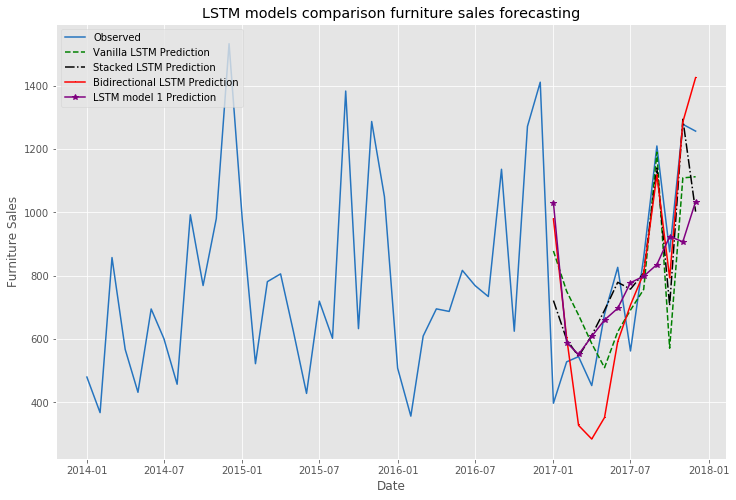

In [159]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction",marker="*",color="purple")
plt.title('LSTM models comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

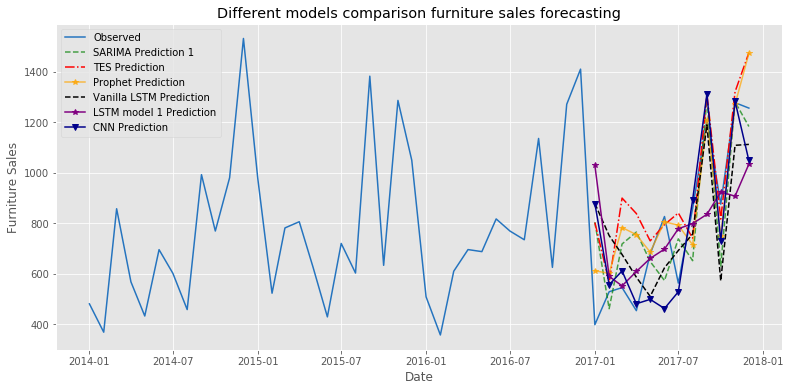

In [160]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df.index, df, color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction",marker="*",color="purple")
#CNN
plt.plot(df[36:].index,preds,label="CNN Prediction",marker='v',color='darkblue')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Different models comparison furniture sales forecasting')
plt.show()

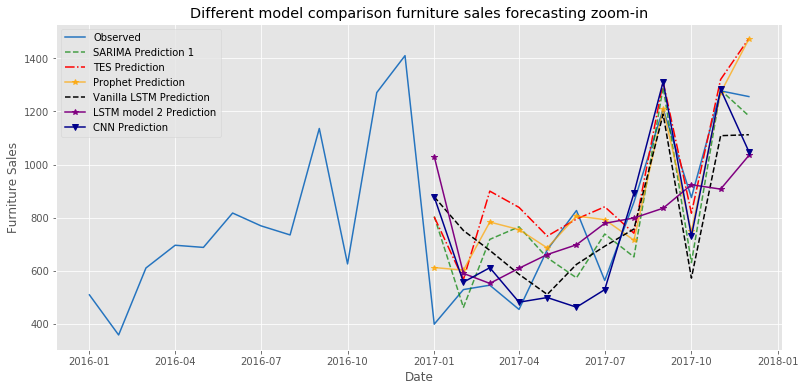

In [161]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df[24:].index, df[24:], color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction",marker="*",color="purple")
#CNN
plt.plot(df[36:].index,preds,label="CNN Prediction",marker='v',color='darkblue')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Different model comparison furniture sales forecasting zoom-in')
plt.show()